In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Maestria en Explotacion de datos y Descubrimiento de conocimiento

## Aprendizaje Automatico

## Trabajo Practico N°2

### Grupo:

* Adrian Marino
* Alejandro Szpak
* Claudio Collado

### Construccion del dataset

Antes que nada, vamos a generar un dataset con todas las observationes, sean habladas(speech) o cantadas(song). Para esto es necesario correr la siguente notebook:

**Notebook**: [Generación de Dataset](https://github.com/magistery-tps/aa-tp2/blob/master/notebooks/generacion-dataset.ipynb)

Borramos audios con ruido generados en corridas previas.

In [4]:
!rm -rvf  ./song/Actor_*/noisy
!rm -rvf  ./speech/Actor_*/noisy

zsh:1: no matches found: ./song/Actor_*/noisy
zsh:1: no matches found: ./speech/Actor_*/noisy


### Librerias

In [5]:
import sys
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Scikitlearn...

from sklearn.ensemble        import RandomForestClassifier, \
                                    AdaBoostClassifier, \
                                    GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, \
                                    LeaveOneGroupOut, \
                                    learning_curve, \
                                    KFold, \
                                    GridSearchCV

from sklearn.metrics        import accuracy_score, \
                                   fbeta_score, \
                                   make_scorer

from sklearn.preprocessing  import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline       import Pipeline


# Librerias propias..

from data   import  Dataset, exclude_columns

from metric import  plot_confusion_matrix, \
                    missing_values_summary, \
                    set_summary, \
                    show_summary, \
                    show_cv_score, \
                    plot_all_train_vs_val

from sound  import  play, play_audio, \
                    get_functional_feats,\
                    create_new_file_with_noise

from model import get_max_score_model, \
                  search_hyper_parameters

from utils import filter_by_index

### Preporcesamiento 

In [6]:
dataset = pd.read_csv('dataset.csv')

In [7]:
dataset.head()

,Unnamed: 0,file_path,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,file,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0,./speech/Actor_23/03-01-04-02-01-01-23.wav,3,1,4,2,1,1,23,./speech/Actor_23/03-01-04-02-01-01-23.wav,...,0.044101,0.007548,0.015374,1.877934,1.425178,0.251667,0.247482,0.367143,0.419309,-39.951572
1,1,./speech/Actor_23/03-01-04-02-02-02-23.wav,3,1,4,2,2,2,23,./speech/Actor_23/03-01-04-02-02-02-23.wav,...,0.011092,0.008020,0.014090,1.694915,0.856531,0.357500,0.072241,0.634000,0.483429,-42.310856
2,2,./speech/Actor_23/03-01-06-02-01-02-23.wav,3,1,6,2,1,2,23,./speech/Actor_23/03-01-06-02-01-02-23.wav,...,0.101003,0.014311,0.014765,2.339181,0.593472,0.635000,0.335000,0.683333,0.449024,-34.312801
3,3,./speech/Actor_23/03-01-07-01-01-02-23.wav,3,1,7,1,1,2,23,./speech/Actor_23/03-01-07-01-01-02-23.wav,...,0.062009,0.011443,0.021647,2.528090,1.424501,0.180000,0.099800,0.416667,0.422834,-44.573288
4,4,./speech/Actor_23/03-01-03-01-01-02-23.wav,3,1,3,1,1,2,23,./speech/Actor_23/03-01-03-01-01-02-23.wav,...,0.032799,0.011666,0.009868,2.153846,0.625000,0.570000,0.320000,0.670000,0.452548,-36.173256


Audio de un speech:

In [8]:
play(dataset[dataset['vocal_channel'] == 1].iloc[0, :])

Audio Cantado:

In [9]:
play(dataset[dataset['vocal_channel'] == 2].iloc[0, :])

Quitamos columnas que no vamos usar como:

In [10]:
example_columns  = list(set(dataset.columns) - set([
    'Unnamed: 0',
    'file',
    'modality',
    'emotional_intensity',
    'statement',
    'repetition',
    'start',
    'end'
]))
target_column = 'emotion'

# Esta dos columnas se usan mas adelantes para hacer fold de los actores 
# y luego para agregar ruido a los audios.
special_columns = ['actor', 'file_path', 'vocal_channel']

In [11]:
def features_target(df):
    filtered = df[example_columns]
    return exclude_columns(filtered, [target_column]),  filtered[[target_column]]

In [12]:
features, target = features_target(dataset)

Analizamos si hay valores faltantes:

In [13]:
missing_values_summary(features)

Series([], dtype: float64)

Partimos en dev y test:

In [14]:
random_state = 1
test_size    = 0.2

In [15]:
X_dev, X_test, y_dev, y_test = train_test_split(
    features, 
    target, 
    test_size    = test_size, 
    stratify     = target, 
    random_state = random_state,
    shuffle      = True
)

A continuacion se muestra el porcentaje de ejemplos por clase y si hay valores faltantes:

In [16]:
set_summary(X_dev, y_dev)

- Features shape: (1961, 91)
- Target shape: (1961, 1)
- Target classes:
	- Clase '2': 15.35 %
	- Clase '3': 15.35 %
	- Clase '4': 15.35 %
	- Clase '5': 15.35 %
	- Clase '6': 15.35 %
	- Clase '7': 7.80 %
	- Clase '8': 7.80 %
- Valores faltantes en features: No hay valores faltantes!


In [17]:
set_summary(X_test, y_test)

- Features shape: (491, 91)
- Target shape: (491, 1)
- Target classes:
	- Clase '2': 15.27 %
	- Clase '3': 15.27 %
	- Clase '4': 15.27 %
	- Clase '5': 15.27 %
	- Clase '6': 15.27 %
	- Clase '7': 7.94 %
	- Clase '8': 7.94 %
- Valores faltantes en features: No hay valores faltantes!


### Analisis de split

Ahora vamos a probar modelos con dos estrategias distintas de cross validation.

#### Estrategia 1

12-fold cross validation armando los folds de forma aleatoria.

In [18]:
cv_strategy_1 = KFold(n_splits=12)

In [19]:
X_Dev_input = exclude_columns(X_dev, special_columns)

Random Forest:

In [20]:
show_cv_score(RandomForestClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 65.9886 %


RandomForestClassifier()

Ada Boost:

In [21]:
show_cv_score(AdaBoostClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 37.8850 %


AdaBoostClassifier()

Gradient Boosting:

In [22]:
%%time
show_cv_score(GradientBoostingClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 63.8520 %
CPU times: user 23.4 ms, sys: 280 µs, total: 23.7 ms
Wall time: 24 s


GradientBoostingClassifier()

XGBoost:

In [23]:
%%time
show_cv_score(XGBClassifier(), X_Dev_input, y_dev, cv_strategy_1)

Accuracy: 63.1341 %
CPU times: user 28.9 ms, sys: 307 µs, total: 29.2 ms
Wall time: 4.97 s


XGBClassifier()

#### Estrategia 2

Leave-2-speakers out. Es decir, 12 folds conteniendo cada uno 2 actores distintos.

La siguiente funcion toma todos los posibles valores de la columna especificada en **input_column** los agrupa en grupos de tamaño **group_size** y luego agrega uni nueva columna (**target_column**) donde se especifica cada fila a que grupo pertenese:

In [24]:
def sample_groups(X, column, group_size):
    numbers = X[column].unique()
    sample  = np.random.choice(numbers, size=len(numbers), replace=False)
    
    return sample.reshape((int(len(numbers) / group_size), group_size))

def set_groups(X, input_column, group_size, target_column):
    tmp = X.copy()

    index = int(max(X[input_column].unique())) + 1
    for group in sample_groups(X, input_column, group_size):
        tmp[target_column] = tmp[input_column].apply(lambda x: index if x in group else x)
        index += 1

    return tmp

In [25]:
sample_groups(X_dev, 'actor', 2)

array([[11, 23],
       [16,  8],
       [18,  2],
       [ 4, 13],
       [15, 12],
       [21,  3],
       [ 6, 22],
       [10,  1],
       [20,  5],
       [14, 19],
       [24,  7],
       [ 9, 17]])

In [26]:
X_dev_tmp = set_groups(
    X_dev, 
    input_column  = 'actor', 
    group_size    = 2, 
    target_column = 'actor'
)
actors_fold_input  = exclude_columns(X_dev_tmp, special_columns)
actors_fold_groups = X_dev_tmp['actor']

Nos quedan 12 grupos de 2 actores cada uno:

In [27]:
len(actors_fold_groups.unique())

12

In [28]:
cv_strategy_2 = LeaveOneGroupOut()

Random Forest:

In [29]:
show_cv_score(RandomForestClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 52.7133 %


RandomForestClassifier()

Ada Boost:

In [30]:
show_cv_score(AdaBoostClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 34.7941 %


AdaBoostClassifier()

Gradient Boosting:

In [31]:
%%time
show_cv_score(GradientBoostingClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 51.7713 %
CPU times: user 25.4 ms, sys: 0 ns, total: 25.4 ms
Wall time: 23.5 s


GradientBoostingClassifier()

XGBoost:

In [32]:
%%time
show_cv_score(XGBClassifier(), actors_fold_input, y_dev, cv_strategy_2, actors_fold_groups)

Accuracy: 52.2429 %
CPU times: user 29.5 ms, sys: 2.85 ms, total: 32.4 ms
Wall time: 5.13 s


XGBClassifier()

**Analisis de division de datos**

Luego de ver los resultados comparando splits random vs. leave one group out, vemos que a priori los splits random funcionan mejor. Pero al analizarlo, creemos que la mejora de performance puede estar dada por contar con datos de todos los actores en todos los folds.

Proyectamos lo que seria un dataset simil productivo, y entendemos que este modelo tiene como objetivo hacer predicciones mas alla de estos actores, por ende un modelo mas "realista" seria aquel que entrene con personas que luego no va a tener en test. 

Decidimos probar las alternativas de split fiteando dos modelos iguales, pero con splits randoms vs manuales, a fines de poder hacer predicciones sobre un held-out con actores no vistos en entrenamiento y ahi poder tener una metrica de comparacion mas realista.

Separamos un conjunto de held-out con dos actores especificos (harcodeados pero elegidos al azar).

In [33]:
X_dev_2  = exclude_columns(features[features.actor.isin([23,20])], special_columns)
X_test_2 = exclude_columns(features[~features.actor.isin([23,20])], special_columns)
y_dev_2  = target[features.actor.isin([23,20])]
y_test_2 = target[~features.actor.isin([23,20])]

Random train-val split:

In [34]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_dev_2, y_dev_2, test_size = 0.8)

rf = RandomForestClassifier()
rf.fit(X_train_2, y_train_2)

y_hat_rf_train_random = rf.predict(X_train_2)
y_hat_rf_val_random   = rf.predict(X_val_2)
y_hat_rf_test_random  = rf.predict(X_test_2)

print('Accuracy:')
print('- Train     : {:.2f} %'.format(accuracy_score(y_train_2, y_hat_rf_train_random) * 100))
print('- Validation: {:.2f} %'.format(accuracy_score(y_val_2,   y_hat_rf_val_random)   * 100))
print('- Test      : {:.2f} %'.format(accuracy_score(y_test_2,  y_hat_rf_test_random)  * 100))

Accuracy:
- Train     : 100.00 %
- Validation: 43.11 %
- Test      : 29.72 %


Split manual train-val:

In [35]:
X_train_group = exclude_columns(features[features.actor.isin([5,17])], special_columns)
X_val_group   = exclude_columns(features[~features.actor.isin([5,17])], special_columns)
y_train_group = target[features.actor.isin([5,17])]
y_val_group   = target[~features.actor.isin([5,17])]

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train_group, y_train_group)

y_hat_rf_train_group = rf.predict(X_train_group)
y_hat_rf_val_group   = rf.predict(X_val_group)
y_hat_rf_test_group  = rf.predict(X_test_2)

print('Accuracy:')
print('- Train     : {:.2f} %'.format(accuracy_score(y_train_group, y_hat_rf_train_group) * 100))
print('- Validation: {:.2f} %'.format(accuracy_score(y_val_group,   y_hat_rf_val_group)   * 100))
print('- Test      : {:.2f} %'.format(accuracy_score(y_test_2,        y_hat_rf_test_group)  * 100))

Accuracy:
- Train     : 100.00 %
- Validation: 32.53 %
- Test      : 38.50 %


A la vista de los resultados corroboramos nuestro supuesto inicial, el split random tiene algo de overfitting ya que es mucho mas sensible a cambios cuando predecimos actores no vistos en entrenamiento. A partir de esto decidimos continuar con estrategia leave-one-group-out, por ser mas realista

### Comparación de desempeño

Comparar el desempeño de Random Forests, AdaBoost, Grading Boosting y XGboost para la division que elegimos en el punto anterior.

In [37]:
X_test_without_special_columns = exclude_columns(X_test, special_columns)
X_Dev_without_special_columns  = exclude_columns(X_dev, special_columns)

emotions = { 
    1: 'Neutral', 
    2: 'Calma',
    3: 'Felicidad',
    4: 'Tristeza', 
    5: 'Enojo',
    6: 'Temor',
    7: 'Amgustia', 
    8: 'Sorpresa'
}

Random Forest:

In [38]:
%%time

shp1 = search_hyper_parameters(
    model       = RandomForestClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'criterion': ['gini','entropy'],
        'max_depth': list(range(1, 30)),
        'ccp_alpha': np.linspace(0, 0.8, 100)
    }
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   22.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:   32.2s finished


CPU times: user 2.52 s, sys: 48.8 ms, total: 2.57 s
Wall time: 33.4 s


Con los mejores hiperparametros encontrados (entrenando con training y evaluando en validation) entrenamos en development y evaluamos en test:

In [39]:
random_forest = RandomForestClassifier()
random_forest.set_params(**shp1.best_params_)
random_forest

RandomForestClassifier(ccp_alpha=0.048484848484848485, criterion='entropy',
                       max_depth=7)

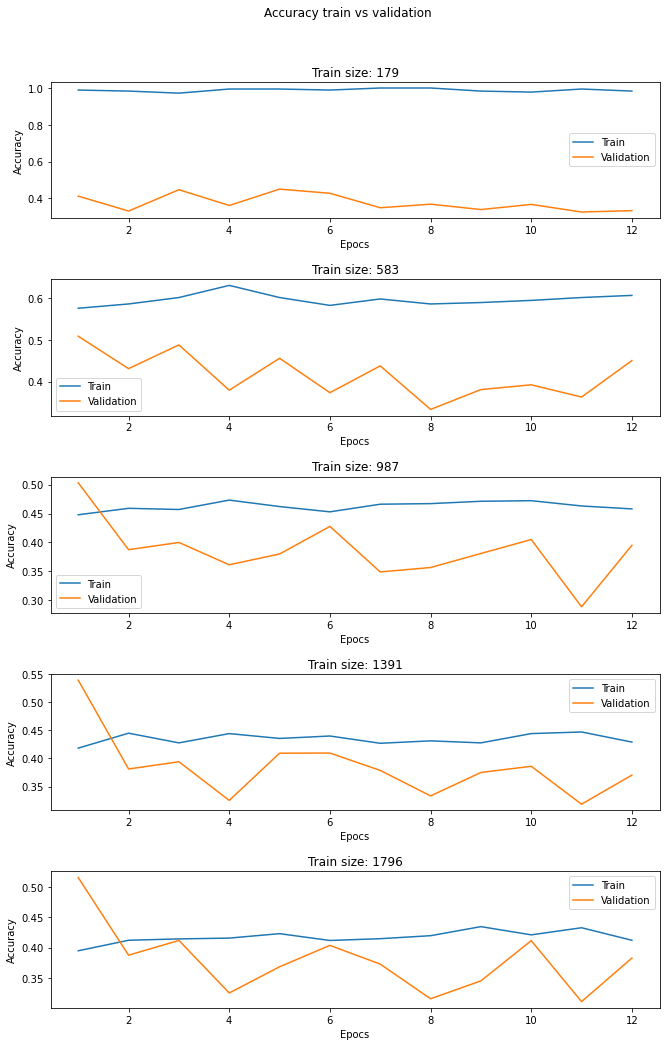

In [40]:
train_sizes, train_scores, valid_scores = learning_curve(
    random_forest,
    X_Dev_without_special_columns, 
    y_dev, 
    cv      = cv_strategy_2,
    groups  = actors_fold_groups
)
plot_all_train_vs_val(train_sizes, train_scores, valid_scores)

Accuracy: 38.6965 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00        38
       Calma       0.40      0.91      0.55        75
   Felicidad       0.33      0.25      0.29        75
    Tristeza       0.17      0.09      0.12        75
       Enojo       0.44      0.76      0.55        75
       Temor       0.36      0.11      0.16        75
    Amgustia       0.44      0.21      0.28        39
    Sorpresa       0.47      0.59      0.52        39

    accuracy                           0.39       491
   macro avg       0.33      0.36      0.31       491
weighted avg       0.33      0.39      0.32       491



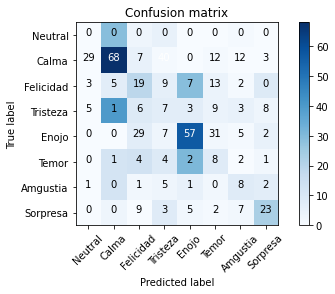

RandomForestClassifier(ccp_alpha=0.048484848484848485, criterion='entropy',
                       max_depth=7)

In [41]:
random_forest = RandomForestClassifier()
random_forest.set_params(**shp1.best_params_)

random_forest.fit(X_Dev_without_special_columns, y_dev)

show_summary(random_forest, X_test_without_special_columns, y_test, emotions)

Ada Boost:

In [42]:
%%time

shp2 = search_hyper_parameters(
    model       = AdaBoostClassifier(), 
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : np.arange(10, 20, 1),
        'learning_rate': np.arange(0, 1, 0.001)
    }
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    7.0s finished


CPU times: user 1.52 s, sys: 37.1 ms, total: 1.56 s
Wall time: 7.34 s


Con los mejores hiperparametros encontrados (entrenando con training y evaluando en validation) entrenamos en development y evaluamos en test:

In [43]:
ada_boost = AdaBoostClassifier()
ada_boost.set_params(**shp2.best_params_)
ada_boost

AdaBoostClassifier(learning_rate=0.436, n_estimators=18)

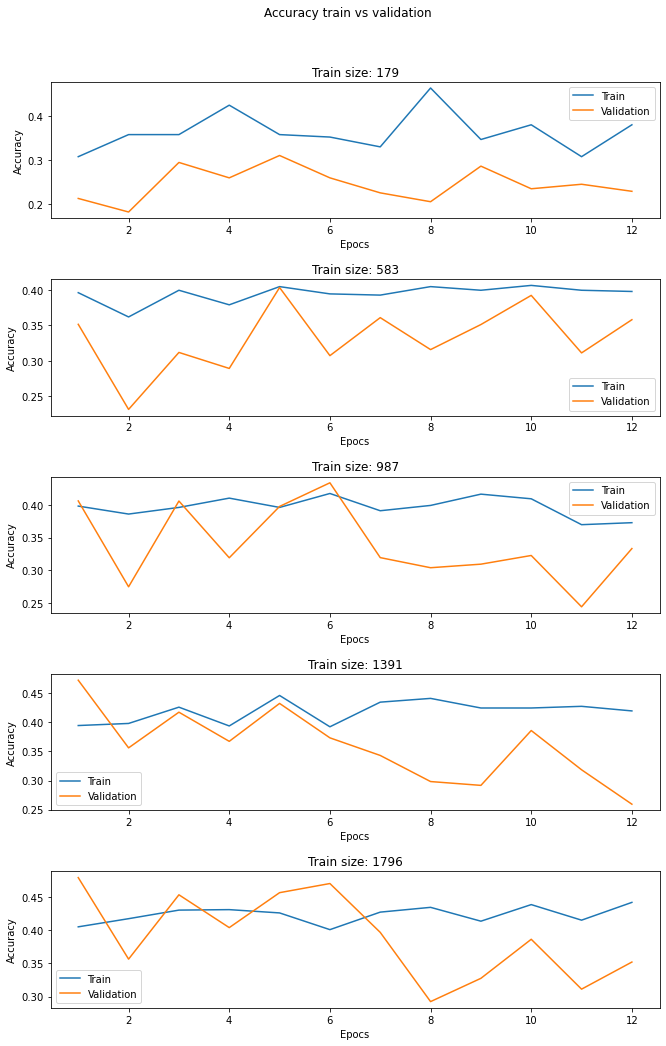

In [44]:
train_sizes, train_scores, valid_scores = learning_curve(
    ada_boost,
    X_Dev_without_special_columns, 
    y_dev, 
    cv      = cv_strategy_2,
    groups  = actors_fold_groups
)
plot_all_train_vs_val(train_sizes, train_scores, valid_scores)

Accuracy: 39.3075 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.30      0.08      0.12        38
       Calma       0.45      0.72      0.56        75
   Felicidad       0.45      0.35      0.39        75
    Tristeza       0.29      0.27      0.28        75
       Enojo       0.41      0.48      0.44        75
       Temor       0.30      0.29      0.30        75
    Amgustia       0.32      0.33      0.32        39
    Sorpresa       0.58      0.49      0.53        39

    accuracy                           0.39       491
   macro avg       0.39      0.38      0.37       491
weighted avg       0.38      0.39      0.38       491



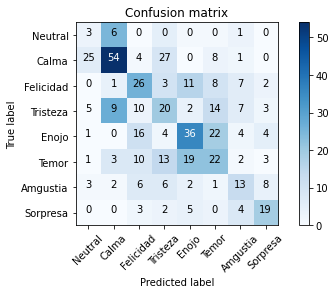

AdaBoostClassifier(learning_rate=0.436, n_estimators=18)

In [45]:
ada_boost = AdaBoostClassifier()
ada_boost.set_params(**shp2.best_params_)

ada_boost.fit(X_Dev_without_special_columns, y_dev)

show_summary(ada_boost, X_test_without_special_columns, y_test, emotions)

Gradient Boosting:

In [46]:
%%time

shp3 = search_hyper_parameters(
    model       = GradientBoostingClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = {
        'n_estimators' : np.arange(1, 15, 1),
        'learning_rate': np.arange(0, 0.2, 0.001)
    }
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   12.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   32.5s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:   51.2s finished


CPU times: user 4.42 s, sys: 4.34 ms, total: 4.43 s
Wall time: 54.3 s


Con los mejores hiperparametros encontrados (entrenando con training y evaluando en validation) entrenamos en development y evaluamos en test:

In [47]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.set_params(**shp3.best_params_)
gradient_boosting

GradientBoostingClassifier(learning_rate=0.127, n_estimators=13)

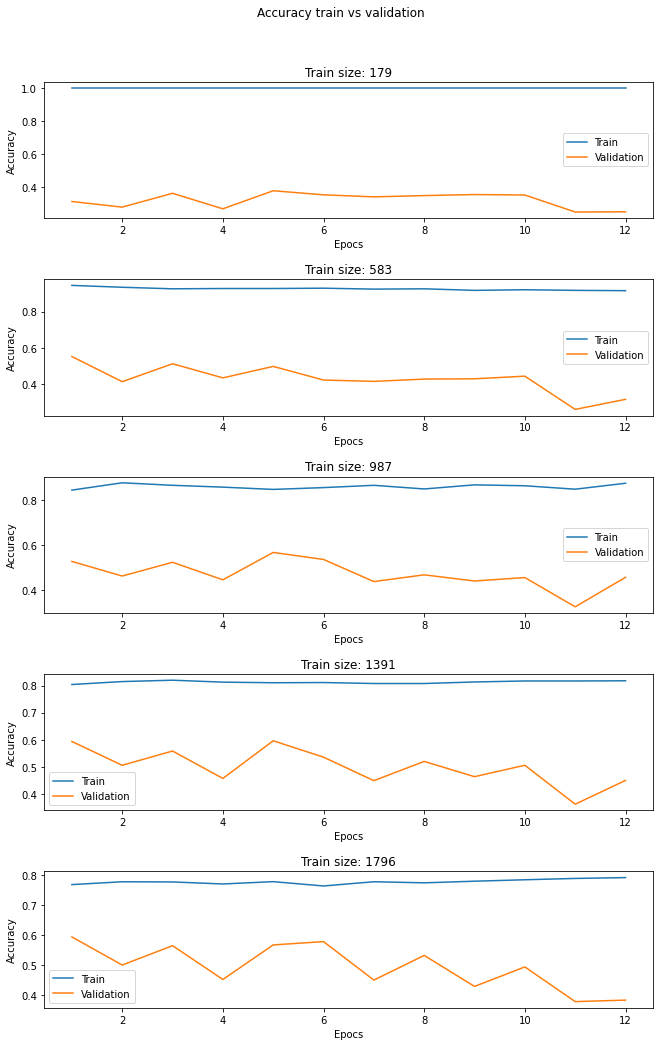

In [48]:
train_sizes, train_scores, valid_scores = learning_curve(
    gradient_boosting,
    X_Dev_without_special_columns, 
    y_dev, 
    cv      = cv_strategy_2,
    groups  = actors_fold_groups
)
plot_all_train_vs_val(train_sizes, train_scores, valid_scores)

Accuracy: 54.7862 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.73      0.58      0.65        38
       Calma       0.65      0.67      0.66        75
   Felicidad       0.51      0.49      0.50        75
    Tristeza       0.46      0.47      0.46        75
       Enojo       0.63      0.68      0.65        75
       Temor       0.52      0.51      0.51        75
    Amgustia       0.38      0.46      0.42        39
    Sorpresa       0.51      0.46      0.49        39

    accuracy                           0.55       491
   macro avg       0.55      0.54      0.54       491
weighted avg       0.55      0.55      0.55       491



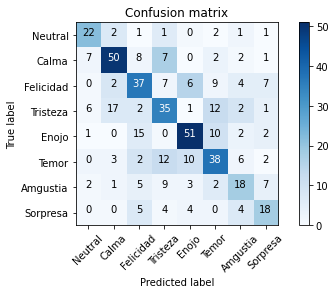

GradientBoostingClassifier(learning_rate=0.127, n_estimators=13)

In [49]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.set_params(**shp3.best_params_)

gradient_boosting.fit(X_Dev_without_special_columns, y_dev)

show_summary(gradient_boosting, X_test_without_special_columns, y_test, emotions)

XGBoost:

In [50]:
hyper_params_grid = {
    # Learning Rate:
    #  - Un valor bajo ayuda al modelo a generalizar mejorpero tambien puede ser muy lento el entrenamiento.
    #  - Un valor alto aumenta la veloridad de entranamiento a costa de disminuir la generalizacion.
    'learning_rate': np.arange(0, 1, 0.001),
    #
    # ---------------------------------------------------------------
    # Parametro de regularización
    # ---------------------------------------------------------------
    #
    # N Estimators: 
    #  - Canto ams estimadores mas reducimos el bias pero aumentamos la varianza(Overfitting).
    #  - Afecta a la velocidad de entrenamiento al aumentar el numero de estimadores.
    'n_estimators' : np.arange(5, 30, 1),
    #
    # Max Depth:
    #  - Es un parametro de regularizacion del modelo.
    #  - A mayor depth mas varianza y menos bias (overfitting).
    'max_depth'   : np.arange(5, 30, 1),
    #
    # Sub Sample: 
    #  - Es la taza de subsampling de observaciones de entrenamiento.
    #  - Varia entre 0 y 1. 1 es el default.
    #  - Define cuantas observaciones de entrenamiento quiero asignar a cada estimador.
    #  - 1: Asignamos una muestra del 100% de las observaciones a cada estimador.
    #  - Redicir este parametro produce un efecto de regularizacion.
    #  - Cuanto mas alto mas overfitting.
    #  - Cuanto mas bajo mas underfitting.
    'subsample'   : np.arange(0, 1, 0.001),
    #
    # Columns Sample by Level:
    #  - Varia entre 0 y 1. 1 es el default.
    #  - Define el porcentaje de columnas a tener en cuenta de nada nivel del arbol.
    #  - Redicir este parametro produce un efecto de regularizacion.
    #  - Cuanto mas alto mas overfitting.
    #  - Cuanto mas bajo mas underfitting.
    'colsample_bylevel': np.arange(0, 1, 0.001),
    # 
    # Columns Sample by Tree:
    #  - Varia entre 0 y 1. 1 es el default.
    #  - Define el porcentaje de columnas a tener en cuenta en cada estimador.
    #  - Redicir este parametro produce un efecto de regularizacion.
    #  - Cuanto mas alto mas overfitting.
    #  - Cuanto mas bajo mas underfitting.
    'colsample_bytree': np.arange(0, 1, 0.001),
    'n_jobs': [24]
}

In [51]:
%%time

shp4 = search_hyper_parameters(
    model       = XGBClassifier(),  
    X           = actors_fold_input, 
    y           = y_dev, 
    cv          = cv_strategy_2,
    groups      = actors_fold_groups,
    params_grid = hyper_params_grid
)

Fitting 12 folds for each of 50 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:  1.4min
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  4.0min
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  5.3min finished


CPU times: user 10.7 s, sys: 192 ms, total: 10.9 s
Wall time: 5min 17s


In [52]:
xgboost = XGBClassifier()
xgboost.set_params(**shp4.best_params_)
xgboost

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              subsample=0.843)

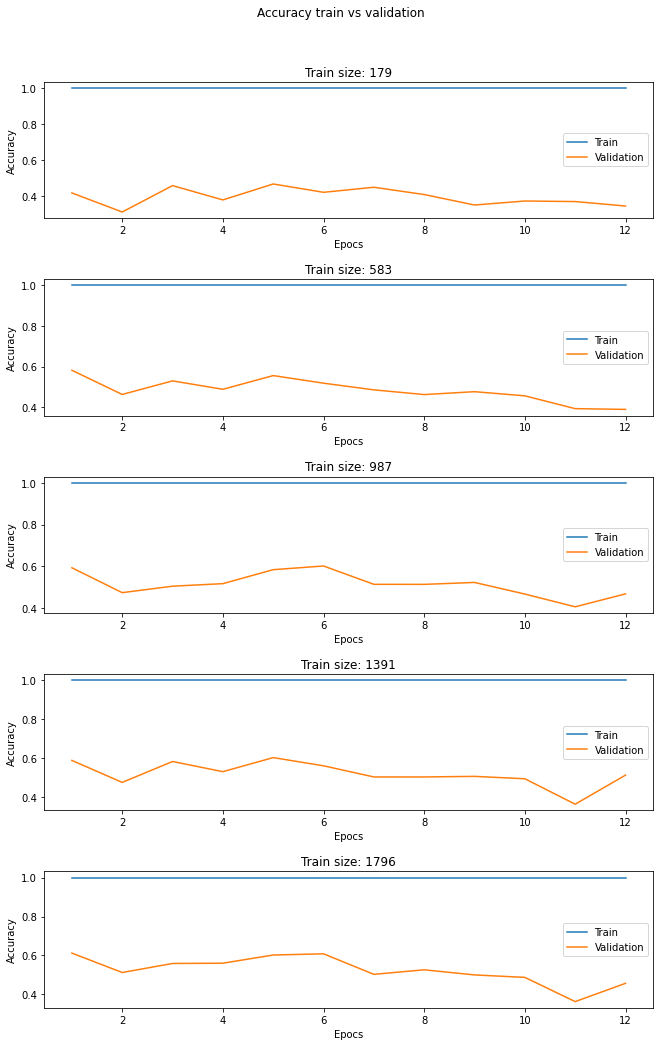

In [53]:
train_sizes, train_scores, valid_scores = learning_curve(
    xgboost,
    X_Dev_without_special_columns, 
    y_dev, 
    cv      = cv_strategy_2,
    groups  = actors_fold_groups
)
plot_all_train_vs_val(train_sizes, train_scores, valid_scores)

Accuracy: 68.0244 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.77      0.71      0.74        38
       Calma       0.76      0.87      0.81        75
   Felicidad       0.66      0.65      0.66        75
    Tristeza       0.60      0.57      0.59        75
       Enojo       0.74      0.79      0.76        75
       Temor       0.65      0.60      0.63        75
    Amgustia       0.54      0.54      0.54        39
    Sorpresa       0.68      0.64      0.66        39

    accuracy                           0.68       491
   macro avg       0.67      0.67      0.67       491
weighted avg       0.68      0.68      0.68       491



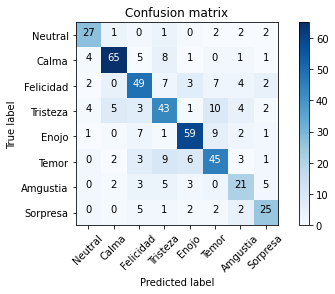

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              objective='multi:softprob', subsample=0.843)

In [54]:
xgboost = XGBClassifier()
xgboost.set_params(**shp4.best_params_)
xgboost.fit(X_Dev_without_special_columns, y_dev)

show_summary(xgboost, X_test_without_special_columns, y_test, emotions)

Ahora seleccionamos el mejor modelo:

In [55]:
models = [random_forest, ada_boost, gradient_boosting, xgboost]

max_score, best_model = get_max_score_model(models, X_test_without_special_columns, y_test)

print('\n\n=> El mejor modelo es "{}" con un accuracy de {:.3f} %.\n\n'.format(type(best_model).__name__, max_score * 100))

- RandomForestClassifier: 0.3870
- AdaBoostClassifier: 0.3931
- GradientBoostingClassifier: 0.5479
- XGBClassifier: 0.6802


=> El mejor modelo es "XGBClassifier" con un accuracy de 68.024 %.




### Evaluación del mejor modelo

Accuracy: 68.0244 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.77      0.71      0.74        38
       Calma       0.76      0.87      0.81        75
   Felicidad       0.66      0.65      0.66        75
    Tristeza       0.60      0.57      0.59        75
       Enojo       0.74      0.79      0.76        75
       Temor       0.65      0.60      0.63        75
    Amgustia       0.54      0.54      0.54        39
    Sorpresa       0.68      0.64      0.66        39

    accuracy                           0.68       491
   macro avg       0.67      0.67      0.67       491
weighted avg       0.68      0.68      0.68       491



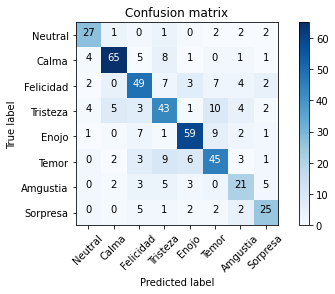

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              objective='multi:softprob', subsample=0.843)

In [56]:
show_summary(best_model, X_test_without_special_columns, y_test, emotions)

Luego con el mejor modelo evaluamos con el conjunto de test para distintas polaciones como:

* speechs vs songs
* femeninas vs masculinas

In [57]:
man_actors   = [x for x in features['actor'].unique() if x % 2 == 0]
woman_actors = [x for x in features['actor'].unique() if x % 2 != 0]

In [58]:
def filter_set(X, y, column, values): return X[X[column].isin(values)], y[X[column].isin(values)]

speechs_features, speechs_y_true = filter_set(X_test, y_test, 'vocal_channel', [1])
songs_features,   songs_y_true   = filter_set(X_test, y_test, 'vocal_channel', [2])

speechs_features = exclude_columns(speechs_features,   special_columns)
songs_features   = exclude_columns(songs_features, special_columns)

In [59]:
man_features,     man_y_true     = filter_set(X_test, y_test, 'actor', man_actors)
woman_features,   woman_y_true   = filter_set(X_test, y_test, 'actor', woman_actors)

man_features   = exclude_columns(man_features,   special_columns)
woman_features = exclude_columns(woman_features, special_columns)

#### Audios Cantados vs Hablados

##### Hablados

Accuracy: 63.1944 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.53      0.50      0.52        16
       Calma       0.70      0.86      0.78        36
   Felicidad       0.63      0.59      0.61        41
    Tristeza       0.55      0.50      0.53        42
       Enojo       0.72      0.76      0.74        41
       Temor       0.62      0.62      0.62        34
    Amgustia       0.54      0.54      0.54        39
    Sorpresa       0.68      0.64      0.66        39

    accuracy                           0.63       288
   macro avg       0.62      0.62      0.62       288
weighted avg       0.63      0.63      0.63       288



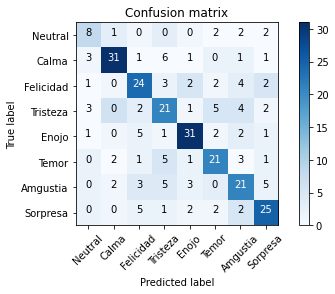

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              objective='multi:softprob', subsample=0.843)

In [60]:
show_summary(best_model, speechs_features, speechs_y_true, emotions)

##### Cantados

Accuracy: 74.8768 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.95      0.86      0.90        22
       Calma       0.83      0.87      0.85        39
   Felicidad       0.69      0.74      0.71        34
    Tristeza       0.65      0.67      0.66        33
       Enojo       0.76      0.82      0.79        34
       Temor       0.69      0.59      0.63        41

    accuracy                           0.75       203
   macro avg       0.76      0.76      0.76       203
weighted avg       0.75      0.75      0.75       203



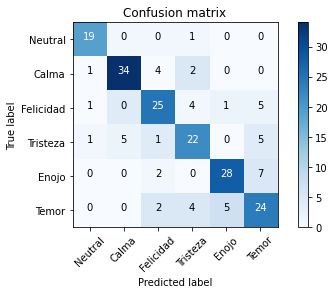

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              objective='multi:softprob', subsample=0.843)

In [61]:
show_summary(best_model, songs_features, songs_y_true, emotions)

##### Feneninos

Accuracy: 68.3333 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.71      0.71      0.71        17
       Calma       0.70      0.97      0.81        29
   Felicidad       0.76      0.59      0.67        37
    Tristeza       0.60      0.55      0.58        38
       Enojo       0.80      0.84      0.82        43
       Temor       0.63      0.56      0.59        34
    Amgustia       0.57      0.60      0.59        20
    Sorpresa       0.61      0.64      0.62        22

    accuracy                           0.68       240
   macro avg       0.67      0.68      0.67       240
weighted avg       0.68      0.68      0.68       240



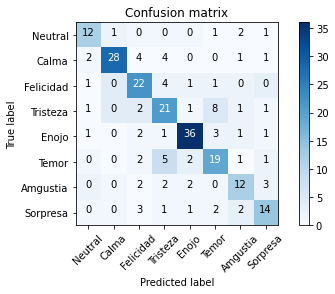

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              objective='multi:softprob', subsample=0.843)

In [62]:
show_summary(best_model, woman_features, woman_y_true, emotions)

##### Masculinos

Accuracy: 67.7291 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.83      0.71      0.77        21
       Calma       0.82      0.80      0.81        46
   Felicidad       0.60      0.71      0.65        38
    Tristeza       0.59      0.59      0.59        37
       Enojo       0.66      0.72      0.69        32
       Temor       0.67      0.63      0.65        41
    Amgustia       0.50      0.47      0.49        19
    Sorpresa       0.79      0.65      0.71        17

    accuracy                           0.68       251
   macro avg       0.68      0.66      0.67       251
weighted avg       0.68      0.68      0.68       251



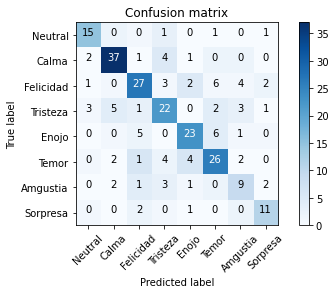

XGBClassifier(colsample_bylevel=0.81, colsample_bytree=0.678,
              learning_rate=0.123, max_depth=25, n_estimators=25, n_jobs=24,
              objective='multi:softprob', subsample=0.843)

In [63]:
show_summary(best_model, man_features, man_y_true, emotions)

### Evaluación ante presencia de ruido

Evaluamos la robustez del mejor modelo ante la presencia de ruido en los audios.

Comparemos un ejemplo sin ruido contra otro con cierto nivel de ruido:

In [64]:
example_path = X_test['file_path'].values[0]
play_audio(example_path)

Para agregar ruido al audio usamos la funcion **create_new_file_with_noise**. Esta funcion agrega ruido al audio usando la relacion senal ruido(SNR):

In [65]:
noise_example_path = create_new_file_with_noise(example_path, level = 10 ** -4)

print(noise_example_path)
play_audio(noise_example_path)

./speech/Actor_11/noisy/c5e81576-d7bf-11eb-832b-d7db6d0408a8-03-01-05-01-01-01-11.wav


Redefinimos la funcion que extrae los features de cada audio. Esta nueva funcion agregar ruido al audio antes de extraer sus features.

In [66]:
def feature_extraction_with_noise(file_path, noise_level):
    if noise_level > 0:
        file_path = create_new_file_with_noise(file_path, noise_level)
    return get_functional_feats(file_path)

Comparemos los features con y sin ruido:

In [67]:
feature_extraction_with_noise(noise_example_path, noise_level = 0.0005)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_11/noisy/noisy/c5ed5ff4-d7bf-11...,0 days,0 days 00:00:03.603604167,31.418354,0.097415,29.394287,30.912973,34.518513,5.124226,25.090624,...,0.012443,0.001255,0.351522,2.785515,1.694915,0.116667,0.075425,0.387143,0.428743,-30.764849


In [68]:
feature_extraction_with_noise(noise_example_path, noise_level = 0)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,./speech/Actor_11/noisy/c5e81576-d7bf-11eb-832...,0 days,0 days 00:00:03.603604167,30.63702,0.131705,27.587395,30.776911,34.519764,6.932369,153.265244,...,0.024894,0.004704,0.105557,3.064067,1.129943,0.2925,0.194984,0.456,0.443468,-36.233032


A continuacion vamos a probar cada uno de los modelos del punto 3 evaluandolos en el conjunto de test e inyectando distintos niveles de ruido. De esta manera podemos compara como se comporta cada modelo ante la presencia de ruido. La funcion **plot_noise_vs_accuracy_curve** entrena el modelo para distintos niveles de ruido y grafica cada nivel de ruido vs accuracy.

In [69]:
def generate_noisy_features(example_paths, noise_level):
    examples = Dataset().search_by_paths(
        example_paths, 
        feature_extract_fn = lambda file_path: feature_extraction_with_noise(file_path, noise_level)
    )
    
    X, y = features_target(examples)
    X = exclude_columns(X, special_columns)

    return X, y

def noise_vs_accuracy_metrics(models, example_paths, y_test, noise_levels):
    accuracy = {type(m).__name__:[] for m in models }
    
    for noise_level in noise_levels:
        X_noise, _ = generate_noisy_features(example_paths, noise_level)
        y_true     = y_test.iloc[X_noise.index.values, :]

        for i, model in enumerate(models):
            acc = model.score(X_noise, y_true)
            accuracy[type(model).__name__].append(acc)
            print('Model: {}, SNR: {}, Accuracy: {:.2f} %'.format(type(model).__name__, noise_level, acc * 100))

    return noise_levels, accuracy

In [70]:
noise_levels = [10 ** -v for v in range(300, 0, -25)] + [10 ** -v for v in range(9, 0, -1)] + list(range(1, 20, 5))
noise_levels

[1e-300,
 1e-275,
 1e-250,
 1e-225,
 1e-200,
 1e-175,
 1e-150,
 1e-125,
 1e-100,
 1e-75,
 1e-50,
 1e-25,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1,
 6,
 11,
 16]

In [71]:
test_example_paths = X_test['file_path'].unique()

Realizamos la grafica SNR vs Accuracy usando el conjunto de test:

In [72]:
noise_levels, accuracy = noise_vs_accuracy_metrics(
    models,
    test_example_paths, 
    y_test, 
    noise_levels
)

  0%|          | 2/491 [00:00<00:45, 10.83it/s]

Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:56,  8.65it/s]

Model: RandomForestClassifier, SNR: 1e-300, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 1e-300, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1e-300, Accuracy: 15.31 %
Model: XGBClassifier, SNR: 1e-300, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:57,  8.55it/s]

Model: RandomForestClassifier, SNR: 1e-275, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 1e-275, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1e-275, Accuracy: 15.31 %
Model: XGBClassifier, SNR: 1e-275, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:53,  9.09it/s]

Model: RandomForestClassifier, SNR: 1e-250, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 1e-250, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1e-250, Accuracy: 15.51 %
Model: XGBClassifier, SNR: 1e-250, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:57,  8.57it/s]

Model: RandomForestClassifier, SNR: 1e-225, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 1e-225, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1e-225, Accuracy: 15.51 %
Model: XGBClassifier, SNR: 1e-225, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:57,  8.57it/s]

Model: RandomForestClassifier, SNR: 1e-200, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 1e-200, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1e-200, Accuracy: 15.92 %
Model: XGBClassifier, SNR: 1e-200, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<01:00,  8.16it/s]

Model: RandomForestClassifier, SNR: 1e-175, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 1e-175, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1e-175, Accuracy: 14.90 %
Model: XGBClassifier, SNR: 1e-175, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.21it/s]

Model: RandomForestClassifier, SNR: 1e-150, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-150, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-150, Accuracy: 29.80 %
Model: XGBClassifier, SNR: 1e-150, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.17it/s]

Model: RandomForestClassifier, SNR: 1e-125, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-125, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-125, Accuracy: 29.80 %
Model: XGBClassifier, SNR: 1e-125, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.18it/s]

Model: RandomForestClassifier, SNR: 1e-100, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-100, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-100, Accuracy: 29.80 %
Model: XGBClassifier, SNR: 1e-100, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.28it/s]

Model: RandomForestClassifier, SNR: 1e-75, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-75, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-75, Accuracy: 29.80 %
Model: XGBClassifier, SNR: 1e-75, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.28it/s]

Model: RandomForestClassifier, SNR: 1e-50, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-50, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-50, Accuracy: 29.80 %
Model: XGBClassifier, SNR: 1e-50, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<01:02,  7.88it/s]

Model: RandomForestClassifier, SNR: 1e-25, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-25, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-25, Accuracy: 29.80 %
Model: XGBClassifier, SNR: 1e-25, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<01:00,  8.10it/s]

Model: RandomForestClassifier, SNR: 1e-09, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-09, Accuracy: 25.92 %
Model: GradientBoostingClassifier, SNR: 1e-09, Accuracy: 28.16 %
Model: XGBClassifier, SNR: 1e-09, Accuracy: 32.45 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.28it/s]

Model: RandomForestClassifier, SNR: 1e-08, Accuracy: 24.90 %
Model: AdaBoostClassifier, SNR: 1e-08, Accuracy: 25.71 %
Model: GradientBoostingClassifier, SNR: 1e-08, Accuracy: 28.16 %
Model: XGBClassifier, SNR: 1e-08, Accuracy: 31.63 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.22it/s]

Model: RandomForestClassifier, SNR: 1e-07, Accuracy: 24.69 %
Model: AdaBoostClassifier, SNR: 1e-07, Accuracy: 25.92 %
Model: GradientBoostingClassifier, SNR: 1e-07, Accuracy: 28.16 %
Model: XGBClassifier, SNR: 1e-07, Accuracy: 32.65 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<01:05,  7.43it/s]

Model: RandomForestClassifier, SNR: 1e-06, Accuracy: 25.10 %
Model: AdaBoostClassifier, SNR: 1e-06, Accuracy: 25.51 %
Model: GradientBoostingClassifier, SNR: 1e-06, Accuracy: 26.12 %
Model: XGBClassifier, SNR: 1e-06, Accuracy: 31.84 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:59,  8.26it/s]

Model: RandomForestClassifier, SNR: 1e-05, Accuracy: 24.08 %
Model: AdaBoostClassifier, SNR: 1e-05, Accuracy: 23.47 %
Model: GradientBoostingClassifier, SNR: 1e-05, Accuracy: 25.71 %
Model: XGBClassifier, SNR: 1e-05, Accuracy: 25.92 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:58,  8.36it/s]

Model: RandomForestClassifier, SNR: 0.0001, Accuracy: 22.65 %
Model: AdaBoostClassifier, SNR: 0.0001, Accuracy: 23.06 %
Model: GradientBoostingClassifier, SNR: 0.0001, Accuracy: 23.06 %
Model: XGBClassifier, SNR: 0.0001, Accuracy: 21.02 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:56,  8.65it/s]

Model: RandomForestClassifier, SNR: 0.001, Accuracy: 17.76 %
Model: AdaBoostClassifier, SNR: 0.001, Accuracy: 16.12 %
Model: GradientBoostingClassifier, SNR: 0.001, Accuracy: 14.49 %
Model: XGBClassifier, SNR: 0.001, Accuracy: 19.59 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:56,  8.65it/s]

Model: RandomForestClassifier, SNR: 0.01, Accuracy: 15.51 %
Model: AdaBoostClassifier, SNR: 0.01, Accuracy: 15.10 %
Model: GradientBoostingClassifier, SNR: 0.01, Accuracy: 14.29 %
Model: XGBClassifier, SNR: 0.01, Accuracy: 15.51 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:56,  8.68it/s]

Model: RandomForestClassifier, SNR: 0.1, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 0.1, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 0.1, Accuracy: 15.31 %
Model: XGBClassifier, SNR: 0.1, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:57,  8.59it/s]

Model: RandomForestClassifier, SNR: 1, Accuracy: 15.51 %
Model: AdaBoostClassifier, SNR: 1, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 1, Accuracy: 15.31 %
Model: XGBClassifier, SNR: 1, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:57,  8.57it/s]

Model: RandomForestClassifier, SNR: 6, Accuracy: 15.10 %
Model: AdaBoostClassifier, SNR: 6, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 6, Accuracy: 15.31 %
Model: XGBClassifier, SNR: 6, Accuracy: 15.31 %
Dataset alredy downloaded!


  0%|          | 1/491 [00:00<00:56,  8.62it/s]

Model: RandomForestClassifier, SNR: 11, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 11, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 11, Accuracy: 15.31 %
Model: XGBClassifier, SNR: 11, Accuracy: 15.31 %
Dataset alredy downloaded!


100%|██████████| 491/491 [00:45<00:00, 10.73it/s]


Model: RandomForestClassifier, SNR: 16, Accuracy: 15.31 %
Model: AdaBoostClassifier, SNR: 16, Accuracy: 15.31 %
Model: GradientBoostingClassifier, SNR: 16, Accuracy: 15.10 %
Model: XGBClassifier, SNR: 16, Accuracy: 15.31 %


In [73]:
sns.set_style("white")
sns.despine()
sns.set(rc={'figure.figsize':(15, 15)})

def plot_metrics(noise_levels, accuracy):
    for model_name in accuracy:
        sns.lineplot(noise_levels, accuracy[model_name], label=model_name)
    plt.xlabel('SNR')
    plt.ylabel('Accuracy')
    plt.show()

<Figure size 432x288 with 0 Axes>

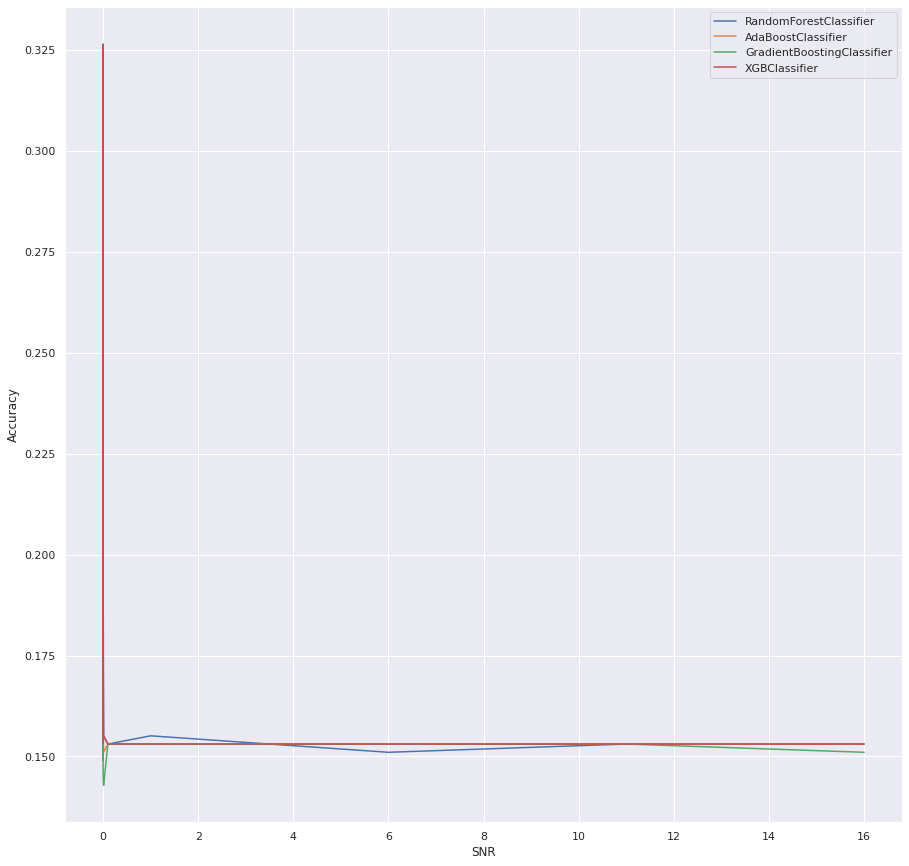

In [74]:
plot_metrics(noise_levels, accuracy)

### Red Neuronal Multicapa

Fitting 12 folds for each of 18 candidates, totalling 216 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   23.3s
[Parallel(n_jobs=24)]: Done 216 out of 216 | elapsed:   33.0s finished


Accuracy: 59.2668 %

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.61      0.45      0.52        38
       Calma       0.69      0.79      0.73        75
   Felicidad       0.43      0.48      0.46        75
    Tristeza       0.52      0.48      0.50        75
       Enojo       0.72      0.75      0.73        75
       Temor       0.54      0.59      0.56        75
    Amgustia       0.71      0.56      0.63        39
    Sorpresa       0.62      0.54      0.58        39

    accuracy                           0.59       491
   macro avg       0.60      0.58      0.59       491
weighted avg       0.59      0.59      0.59       491



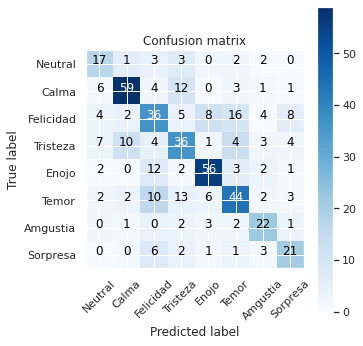

GridSearchCV(cv=LeaveOneGroupOut(),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('estimator', MLPClassifier())]),
             n_jobs=24,
             param_grid=[{'estimator': [MLPClassifier(learning_rate_init=0.0001,
                                                      max_iter=300,
                                                      random_state=42)],
                          'estimator__activation': ['logistic', 'tanh', 'relu'],
                          'estimator__alpha': [0.0001, 0.001, 0.005],
                          'estimator__early_stopping': [True, False],
                          'estimator__learning_rate_init': [0.0001],
                          'estimator__max_iter': [300],
                          'estimator__solver': ['adam'],
                          'scaler': [StandardScaler()]}],
             scoring=make_scorer(accuracy_score), verbose=1)

In [78]:
param_grid = [
    {
     'scaler'                       : [StandardScaler()],
     'estimator'                    : [MLPClassifier(random_state=42)],
     'estimator__solver'            : ['adam'],
     'estimator__learning_rate_init': [0.0001],
     'estimator__max_iter'          : [300],
     'estimator__activation'        : ['logistic', 'tanh', 'relu'],
     'estimator__alpha'             : [0.0001, 0.001, 0.005],
     'estimator__early_stopping'    : [True, False]
    }
]

pipeline = Pipeline([('scaler', None), ('estimator', MLPClassifier())])

grid_search = GridSearchCV(
    estimator  = pipeline, 
    param_grid = param_grid, 
    scoring    = make_scorer(accuracy_score), 
    n_jobs     = 24, 
    cv         = cv_strategy_2, 
    refit      = True, 
    verbose    = 1
)

grid_search.fit(
    X_Dev_without_special_columns, 
    y_dev, 
    groups = actors_fold_groups
)

sns.set(rc={'figure.figsize':(5, 5)})
show_summary(grid_search, X_test_without_special_columns, y_test, emotions)